In [64]:
# context_encoders 64*64
import glob
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Activation, Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from IPython import display

In [ ]:

class ContextEncoder():
    def __init__(self):
        self.img_rows = 256
        self.img_cols = 256

        self.mask_height = 64
        self.mask_width = 64

        self.channels = 3

        self.sum_classes = 1

        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # 生成器判别器
        self.generator = self.build_generator()

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # 准备联合训练
        self.discriminator.trainable = False
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)
        valid = self.discriminator(gen_missing)
        self.combined = Model(masked_img, [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
                              loss_weights=[0.999, 0.001],
                              optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        # 先定义编码器

        # 输入256*256*3的遮挡图
        model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # ——>128*12*64 特征图
        model.add(Conv2D(64, kernel_size=4, strides=2,  padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(128, kernel_size=4, strides=2,  padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=4, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # 8*8*512

        # 进入中间层

        # Decoder ——>上采样＋卷积
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=4, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        # 第一层upconv完成 ——> 16*16*256

        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        # 32*32*128

        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        # 64*64*64

        model.add(Conv2D(self.channels, kernel_size=2, padding='same'))
        model.add(Activation('tanh'))

        # 64*64*3 输出完成

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        # 64*64*3
        model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=self.missing_shape, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # 32*32*64

        model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # 16*16*128

        model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # 8*8*256

        model.add(Conv2D(512, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # 4*4*512

        model.add(Flatten())
        # 16384

        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(self.missing_shape)
        validity = model(img)
        # 完成了输入64*64*3 图片 输出真是概率

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        if os.path.exists('saved_model/discriminator_weights.hdf5') and os.path.exists(
                'saved_model/generator_weights.hdf5'):
            self.discriminator.load_weights('saved_model/discriminator_weights.hdf5')
            self.generator.load_weights('saved_model/generator_weights.hdf5')
            print('-------------load the model-----------------')

        X_train = []

        list = glob.glob(r'train_images/arch/*.jpg')
        for l in list:
            im = cv2.imread(l)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X_train.append(im)
        X_train = np.array(X_train)

        print('X_train.shape', X_train.shape, "———————————————————数据集加载完成——————————")

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # 训练判别器
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            imgs = imgs / 175.5 - 1.  # -1 - 1
            # 随机抽取batchsize个真实图像

            masked_imgs, missing_parts, _ = self.mask_randomly(imgs)
            # masked_imgs就代表了遮挡的batch个图像
            # missing_parts就代表了丢失的batch个图像块

            gen_missing = self.generator.predict(masked_imgs)
            # 通过真假两个图训练判别器
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # 返回损失值和准确率

            # 训练生成器
            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])
            # 在这里 使用的是 MSE ADloss

            # 打印损失值以及准确率
            print("%d [D loss: %f, acc: %.2f%%] [G loss mse: %f, ad loss: %f]" % (
                epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))
            # d_loss[0]判别器损失, d_loss[1]准确率, g_loss[0]联合模型的重建损失, g_loss[1]联合模型的对抗损失
            if epoch % sample_interval == 0:
                # 随机生成5个整数
                idx = np.random.randint(0, X_train.shape[0], 5)
                imgs = X_train[idx]
                imgs = imgs / 127.5 - 1.
                self.sample_images(epoch, imgs)
            if epoch % 1000 == 0:
                self.save_model()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                       "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

    def sample_images(self, epoch, imgs):
        r, c = 3, 5
        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_randomly(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c)
        # imshow 绘制原图 遮挡图 和修复图
        for i in range(c):
            axs[0, i].imshow(imgs[i, :, :])
            axs[0, i].axis('off')
            axs[1, i].imshow(masked_imgs[i, :, :])
            axs[1, i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1[i]:y2[i], x1[i]:x2[i], :] = gen_missing[i]
            axs[2, i].imshow(filled_in)
            axs[2, i].axis('off')
        fig.savefig("images/%d.png" % epoch, dpi=256)
        plt.close()

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows-self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        # 复制原图 待遮挡（这里只需要完成像素置0即可完成遮挡）
        masked_imgs = np.empty_like(imgs)

        # 丢失区域内容大小尺寸定义完毕 （这里只需要将丢失的像素点复制进来）
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))

        for i, img in enumerate(imgs):
            masked_img = img.copy()  # 首先复制原图 也就是准备完成遮挡单个图
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]  # 随机生成的每个遮挡坐标
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0  # 置0操作 完成遮挡
            masked_imgs[i] = masked_img  # 存入 masked_imgs
        return masked_imgs, missing_parts, (y1, y2, x1, x2)


if __name__ == '__main__':
    context_encoder = ContextEncoder()
    context_encoder.train(epochs=30000, batch_size=16, sample_interval=50)



# context encoder v2

In [63]:
# context_encoders 64*64
import glob
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, UpSampling2D,Reshape,Lambda, concatenate
from tensorflow.keras.layers import Activation, Input, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time

In [5]:

train_dir = 'data/train/'
test_dir = 'data/test/'
weight_path = "weights/"
result_path = 'result'

num_epochs = 10
learning_rate = 0.001
image_shape = (256, 256,3)
mask_shape = (128,128,3)
batch_size=5

mask_height_min = 64
mask_width_min = 64

hole_min=64
hole_max=128

alpha = 0.5
Tc =10


In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=1, input_shape=image_shape, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2D(128, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2D(256, kernel_size=3, strides=2,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2D(256, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2D(256, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2D(256,kernel_size=3, strides=1, dilation_rate=2,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256,kernel_size=3, strides=1, dilation_rate=4,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256,kernel_size=3, strides=1, dilation_rate=8,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256,kernel_size=3, strides=1, dilation_rate=16,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(32, kernel_size=3, strides=1,  padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [7]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)    

In [8]:
def make_discriminator_model():
    # def crop_image(img, crop):
    #     return tf.image.crop_to_bounding_box(img,
    #                                          crop[1],
    #                                          crop[0],
    #                                          crop[3] - crop[1],
    #                                          crop[2] - crop[0])

    # in_pts = Input(shape=(4,), dtype='int32')
    # cropping = Lambda(lambda x: K.map_fn(lambda y: crop_image(y[0], y[1]), elems=x, dtype=tf.float32),
    #                   output_shape=mask_shape)
    # g_img = Input(shape=image_shape)
    # l_img = cropping([g_img,in_pts])
    # l_img.set_shape((None,) + mask_shape)

    g_img = Input(shape=image_shape)
    l_img = Input(shape=mask_shape)


    x_l = Conv2D(64, kernel_size=5, strides=2, padding='same')(l_img)
    x_l = BatchNormalization()(x_l)
    x_l = Activation('relu')(x_l)
    x_l = Conv2D(128, kernel_size=5, strides=2, padding='same')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation('relu')(x_l)
    x_l = Conv2D(256, kernel_size=5, strides=2, padding='same')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation('relu')(x_l)
    x_l = Conv2D(512, kernel_size=5, strides=2, padding='same')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation('relu')(x_l)
    x_l = Conv2D(512, kernel_size=5, strides=2, padding='same')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation('relu')(x_l)
    x_l = Flatten()(x_l)
    x_l = Dense(1024, activation='relu')(x_l)

    x_g = Conv2D(64, kernel_size=5, strides=2, padding='same')(g_img)
    x_g = BatchNormalization()(x_g)
    x_g = Activation('relu')(x_g)
    x_g = Conv2D(128, kernel_size=5, strides=2, padding='same')(x_g)
    x_g = BatchNormalization()(x_g)
    x_g = Activation('relu')(x_g)
    x_g = Conv2D(256, kernel_size=5, strides=2, padding='same')(x_g)
    x_g = BatchNormalization()(x_g)
    x_g = Activation('relu')(x_g)
    x_g = Conv2D(512, kernel_size=5, strides=2, padding='same')(x_g)
    x_g = BatchNormalization()(x_g)
    x_g = Activation('relu')(x_g)
    x_g = Conv2D(512, kernel_size=5, strides=2, padding='same')(x_g)
    x_g = BatchNormalization()(x_g)
    x_g = Activation('relu')(x_g)
    x_g = Conv2D(512, kernel_size=5, strides=2, padding='same')(x_g)
    x_g = BatchNormalization()(x_g)
    x_g = Activation('relu')(x_g)
    x_g = Flatten()(x_g)
    x_g = Dense(1024, activation='relu')(x_g)

    x = concatenate([x_l, x_g])
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=[g_img, l_img], outputs=x)


In [9]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 128, 128, 64) 256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
______________________________________________________________________________________________

In [56]:
def mask_randomly(imgs):
    p_y1 =  np.random.randint(0, image_shape[0]-mask_shape[0], imgs.shape[0])
    p_y2 = p_y1+mask_shape[0]
    p_x1 =  np.random.randint(0, image_shape[1]-mask_shape[1], imgs.shape[0])
    p_x2 = p_x1+mask_shape[1]

    w, h = np.random.randint(hole_min, hole_max, 2)
    y1 = np.random.randint(0, mask_shape[0]-h, imgs.shape[0])
    y2 = y1 + h
    x1 = np.random.randint(0, mask_shape[1] -w, imgs.shape[0])
    x2 = x1 + w

    croped_imgs = np.empty((imgs.shape[0],mask_shape[0],mask_shape[1],mask_shape[2]),dtype=np.uint8)
    masked_imgs = np.empty_like(imgs)

    for i,img in enumerate(imgs):
        img = np.array(img)
        croped_imgs[i]=img[p_y1[i]:p_y2[i],p_x1[i]:p_x2[i],:]
        masked_img=img[p_y1[i]:p_y2[i],p_x1[i]:p_x2[i],:]
        masked_img[y1[i]:y2[i],x1[i]:x2[i],:]=0
        img[p_y1[i]:p_y2[i],p_x1[i]:p_x2[i],:]=masked_img
        masked_imgs[i]=img
        

    return masked_imgs,croped_imgs,(p_y1,p_y2,p_x1,p_x2)

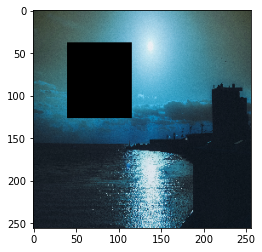

In [57]:
train_list_dir = os.listdir(train_dir)
train_list_dir.sort()
train_filenames = [train_dir + filename for filename in train_list_dir]

def train_generator():
    for train_file_name in train_filenames:
        image = handle_data(train_file_name)

        yield  image

def handle_data(train_filenames):
    image = cv2.resize(
        cv2.imread(train_filenames), (image_shape[0],image_shape[1]))
    return np.array(image)

train_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.uint8))

train_dataset = train_dataset.shuffle(buffer_size=len(train_list_dir))
train_dataset = train_dataset.batch(batch_size)


for data in train_dataset:
    masked_imgs,croped_imgs,(p_y1,p_y2,p_x1,p_x2) = mask_randomly(data)
    break
plt.imshow(masked_imgs[0])

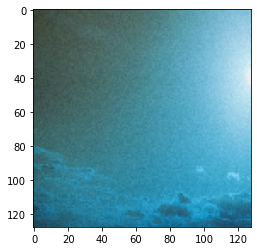

In [59]:
ig = data[0][p_y1[0]:p_y2[0],p_x1[0]:p_x2[0],:]
plt.imshow(ig)


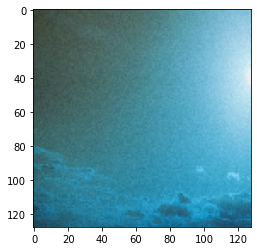

In [60]:
plt.imshow(croped_imgs[0])


In [27]:
test1 = tf.convert_to_tensor(masked_imgs/.255)
imggen = generator(test1)
print(imggen.shape)

(5, 256, 256, 3)


In [28]:
test2 = tf.convert_to_tensor(croped_imgs/.255)
imggen = discriminator([test1,test2])
print(imggen)

tf.Tensor(
[[0.05659857]
 [0.04169878]
 [0.38467544]
 [0.7255966 ]
 [0.00194068]], shape=(5, 1), dtype=float32)


In [41]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [42]:
#define loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(images,fake_output):
    return tf.keras.losses.MSE(images, fake_output)

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)

In [44]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [65]:
@tf.function
def train_step(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      masked_imgs,croped_imgs,(p_y1,p_y2,p_x1,p_x2) = mask_randomly(images)
      generated_images = generator(masked_imgs, training=True)

      generated_croped_images = np.empty_like(croped_imgs)
      for i,img in enumerate(generated_images):
        generated_croped_images[i]= img[p_y1[i]:p_y2[i],p_x1[i]:p_x2[i],:]    

      real_output = discriminator([images,croped_imgs], training=True)
      fake_output = discriminator([generated_images,tf.convert_to_tensor(generated_croped_images)], training=True)

      gen_loss = generator_loss(images,fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [66]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))



In [67]:
train(train_dataset, num_epochs)

NotImplementedError: in user code:

    <ipython-input-65-bb87cce9acaa>:5 train_step  *
        masked_imgs,croped_imgs,(p_y1,p_y2,p_x1,p_x2) = mask_randomly(images)
    <ipython-input-56-965fe3f20f2b>:14 mask_randomly  *
        masked_imgs = np.empty_like(imgs)
    <__array_function__ internals>:5 empty_like  **
        
    C:\Users\11549\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (images:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
